# Regression

In [1]:
import os
import sys
import pickle
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.special import expit
import pystan
import multiprocessing

In [2]:
import import_ipynb
from model import Model

importing Jupyter notebook from model.ipynb
The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


In [3]:
multiprocessing.set_start_method("fork") # For multiprocessing in stan
sns.set()  # Nice plot aesthetic
np.random.seed(101)

In [4]:
FIG_FOLDER = 'fig'
SOURCE_FOLDER = os.path.join('data', 'source')
BACKUP_FOLDER = os.path.join('data', 'backup')
print(f"The source folder is: {os.path.abspath(SOURCE_FOLDER)}")
print(f"The figure folder is: {os.path.abspath(FIG_FOLDER)}")
print(f"The backup folder is: {os.path.abspath(BACKUP_FOLDER)}")

# Create folders
for f in SOURCE_FOLDER, FIG_FOLDER, BACKUP_FOLDER:
    os.makedirs(f, exist_ok=True)

The source folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/source
The figure folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/fig
The backup folder is: /Users/aureliennioche/Documents/PythonProjects/ProspecTonk/data/backup


### Load the results

In [5]:
df_fit = pd.read_csv(os.path.join(BACKUP_FOLDER, f"df_fit_overall.csv"))
for c in ("date_begin", "date_end"):
    df_fit[c] = pd.to_datetime(df_fit[c])
df_fit.drop(df_fit.filter(regex="Unname"),axis=1, inplace=True)
df_fit

,distortion,precision,risk_aversion,date_begin,date_end,monkey,condition,n
0,0.200000,10.000000,0.990000,2020-06-25,2020-10-25,Ola,gain,837
1,0.259690,5.822620,-0.990000,2020-06-25,2020-10-25,Ola,loss,844
2,1.037591,3.411750,0.408652,2020-06-25,2020-10-25,Abr,gain,1873
3,0.643684,0.496632,-0.406756,2020-06-25,2020-10-25,Abr,loss,1874
4,1.500298,2.562927,-0.172519,2020-06-25,2020-10-25,Nem,gain,800
5,0.618010,0.304122,-0.437583,2020-06-25,2020-10-25,Nem,loss,803
6,1.258861,1.165837,-0.345788,2020-06-25,2020-10-25,Alv,gain,1825
7,0.776557,0.334887,-0.493689,2020-06-25,2020-10-25,Alv,loss,1824
8,0.200000,1.572916,0.990000,2020-06-25,2020-10-25,Ner,gain,465
9,1.767768,6.214167,0.535331,2020-06-25,2020-10-25,Ner,loss,462


In [6]:
df_elo = pd.read_csv(os.path.join(BACKUP_FOLDER, "df_elo.csv"), index_col=0)
df_elo.index = pd.to_datetime(df_elo.index)
df_elo

,nem,yak,ner,yoh,nen,wot,pac,las,anu,ola,...,olg,jea,pat,bar,ces,lad,ber,dor,eri,fic
date,,,,,,,,,,,,,,,,,,,,,
2016-10-25,1024,1009,1018,984,991,1010,991,982,991,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-26,1032,1009,1018,1003,991,1010,982,964,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-27,1032,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-28,1041,1009,1018,1003,991,1010,982,956,991,999,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
2016-10-29,1063,1009,1018,1011,991,1010,975,941,984,1008,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-21,938,1243,961,840,1018,1234,1379,713,1117,1287,...,933,760,841,1083,837,753,743,766,702,579
2020-10-22,970,1243,962,840,1018,1234,1347,716,1105,1296,...,935,755,841,1070,832,753,743,795,702,566
2020-10-23,971,1243,970,840,1018,1234,1347,735,1105,1296,...,920,751,841,1072,838,753,758,773,668,566


In [7]:
elo = []

for _, row in df_fit.iterrows():
        
    m = row.monkey
    begin = row.date_begin
    end = row.date_end
        
    df_elo_m = df_elo[m.lower()]
    df_elo_m = df_elo_m[(df_elo_m.index >= begin) & (df_elo_m.index <= end)]
    elo.append(np.mean(df_elo_m))
        

df_fit['elo'] = elo
df_fit

,distortion,precision,risk_aversion,date_begin,date_end,monkey,condition,n,elo
0,0.200000,10.000000,0.990000,2020-06-25,2020-10-25,Ola,gain,837,1364.308943
1,0.259690,5.822620,-0.990000,2020-06-25,2020-10-25,Ola,loss,844,1364.308943
2,1.037591,3.411750,0.408652,2020-06-25,2020-10-25,Abr,gain,1873,1239.707317
3,0.643684,0.496632,-0.406756,2020-06-25,2020-10-25,Abr,loss,1874,1239.707317
4,1.500298,2.562927,-0.172519,2020-06-25,2020-10-25,Nem,gain,800,928.788618
5,0.618010,0.304122,-0.437583,2020-06-25,2020-10-25,Nem,loss,803,928.788618
6,1.258861,1.165837,-0.345788,2020-06-25,2020-10-25,Alv,gain,1825,1243.382114
7,0.776557,0.334887,-0.493689,2020-06-25,2020-10-25,Alv,loss,1824,1243.382114
8,0.200000,1.572916,0.990000,2020-06-25,2020-10-25,Ner,gain,465,999.463415
9,1.767768,6.214167,0.535331,2020-06-25,2020-10-25,Ner,loss,462,999.463415


## Using Stan

### Format the data

In [8]:
left = df_fit[df_fit.condition == "loss"]
right = df_fit[df_fit.condition == "gain"]
df = pd.merge(left, right, on=("monkey", "elo", "date_begin", "date_end"), suffixes=('_loss', '_gain'))
df.drop("condition_gain", axis=1, inplace=True)
df.drop("condition_loss", axis=1, inplace=True)
df

,distortion_loss,precision_loss,risk_aversion_loss,date_begin,date_end,monkey,n_loss,elo,distortion_gain,precision_gain,risk_aversion_gain,n_gain
0,0.259690,5.822620,-0.990000,2020-06-25,2020-10-25,Ola,844,1364.308943,0.200000,10.000000,0.990000,837
1,0.643684,0.496632,-0.406756,2020-06-25,2020-10-25,Abr,1874,1239.707317,1.037591,3.411750,0.408652,1873
2,0.618010,0.304122,-0.437583,2020-06-25,2020-10-25,Nem,803,928.788618,1.500298,2.562927,-0.172519,800
3,0.776557,0.334887,-0.493689,2020-06-25,2020-10-25,Alv,1824,1243.382114,1.258861,1.165837,-0.345788,1825
4,1.767768,6.214167,0.535331,2020-06-25,2020-10-25,Ner,462,999.463415,0.200000,1.572916,0.990000,465
5,0.863882,0.261133,-0.580418,2020-06-25,2020-10-25,Ala,1658,1126.666667,1.341355,0.548266,0.081717,1663
6,0.628614,0.265012,-0.424345,2020-06-25,2020-10-25,Bar,2329,1038.162602,0.721588,0.727562,-0.206917,2335
7,0.944152,0.316984,-0.471549,2020-06-25,2020-10-25,Ces,1291,798.195122,0.818277,1.013631,-0.051428,1297
8,0.637796,0.357502,-0.495551,2020-06-25,2020-10-25,Oli,1015,1175.276423,0.778743,1.922580,-0.441756,1021
9,0.890873,0.428373,-0.599211,2020-06-25,2020-10-22,Pac,532,1383.416667,0.426462,1.561912,0.990000,543


In [9]:
data = df.to_dict('list')
data['N'] = len(data["distortion_gain"])
data.pop("date_begin")
data.pop("date_end")
data.pop("monkey")
data

{'distortion_loss': [0.2596903716856736,
  0.6436839277603266,
  0.6180096280518853,
  0.7765568745025209,
  1.7677680650552523,
  0.8638823294108969,
  0.6286141587218131,
  0.94415237684982,
  0.6377955013722281,
  0.8908730759734372,
  0.7270492870764438,
  0.4881313120542409,
  0.4937658674367883,
  0.3828370246510879,
  0.2],
 'precision_loss': [5.822619945225822,
  0.4966323917982544,
  0.3041221860439945,
  0.3348866263305928,
  6.214167442840885,
  0.2611329749526447,
  0.2650119273984453,
  0.3169841380853655,
  0.3575019990858413,
  0.4283732411455023,
  0.2888344970065536,
  0.5054221542910847,
  0.569557077603801,
  1.1059637748542808,
  10.0],
 'risk_aversion_loss': [-0.99,
  -0.4067561408640994,
  -0.437582988812753,
  -0.4936885243048738,
  0.5353312342928498,
  -0.5804180133343163,
  -0.4243452555865086,
  -0.4715492329535469,
  -0.4955513617424102,
  -0.5992113073974605,
  -0.6909418046598802,
  -0.4515606585443152,
  -0.488830054387355,
  -0.4907891568488499,
  -0.99]

\begin{equation}
elo \sim \beta_0 + \beta_{risk^+} risk^+ + ...
\end{equation}
with:
\begin{equation}
\begin{split}
e &\sim \mathcal{N} (\alpha + \beta X, \sigma) \\
\end{split}
\end{equation}

### Model definition

In [10]:
model = """
data {
    int<lower=0> N;
    vector[N] distortion_gain;
    vector[N] risk_aversion_gain;
    vector[N] precision_gain;
    vector[N] distortion_loss;
    vector[N] risk_aversion_loss;
    vector[N] precision_loss;
    vector[N] elo;
}
parameters {
    real beta0;
    real beta_dist_gain;
    real beta_risk_gain;
    real beta_prec_gain;
    real beta_dist_loss;
    real beta_risk_loss;
    real beta_prec_loss;
    real<lower=0> sigma;
}
model {
    elo ~ normal(beta0 
    + beta_dist_gain * distortion_gain
    + beta_risk_gain * risk_aversion_gain
    + beta_prec_gain * precision_gain
    + beta_dist_loss * distortion_loss
    + beta_risk_loss * risk_aversion_loss
    + beta_prec_loss * precision_loss
    , sigma);
}
"""

### Compile the model

In [11]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_file = os.path.join(BACKUP_FOLDER, 'regression_model.pkl')
if not os.path.exists(bkp_file) or force_compilation:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aef5dc0ffcff107725ff680927909285 NOW.


### Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [12]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
fit

Inference for Stan model: anon_model_aef5dc0ffcff107725ff680927909285.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0          1059.3   27.56 661.71 -234.8 677.41 1091.1 1450.0 2332.5    576   1.01
beta_dist_gain -353.7    8.95 290.98 -948.5 -521.3 -354.5 -199.3 279.68   1057   1.01
beta_risk_gain -118.0    6.75 238.58 -598.0 -261.1 -118.9  23.66 371.33   1248    1.0
beta_prec_gain   33.9    0.82  30.36 -29.17   15.3  34.15  52.99  94.01   1383    1.0
beta_dist_loss  242.3   17.48 464.09 -696.1 -34.24 240.61 531.58 1164.8    705    1.0
beta_risk_loss -250.1   20.02 501.27  -1239 -544.4 -252.6  57.03  768.2    627   1.01
beta_prec_loss -31.33    1.18  40.36 -109.6 -56.62 -32.78  -8.11   58.4   1162    1.0
sigma           302.8    5.14  98.41 178.32 236.23 281.86 345.79 532.66    366   1.01
lp__           -86.23     0.2    3.2 -9

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [13]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta0,1059.300747,27.562789,661.713399,-234.888097,677.406143,1091.139579,1450.091950,2332.500803,576.359604,1.008301
beta_dist_gain,-353.775320,8.948689,290.980413,-948.594943,-521.381190,-354.513900,-199.355925,279.678977,1057.325456,1.005078
beta_risk_gain,-118.026899,6.753257,238.581842,-598.076829,-261.125229,-118.989078,23.660183,371.333963,1248.096758,1.003956
beta_prec_gain,33.895261,0.816521,30.364803,-29.173661,15.295171,34.152158,52.993180,94.005639,1382.948555,1.001602
beta_dist_loss,242.296955,17.476011,464.091228,-696.095032,-34.236642,240.605682,531.580386,1164.890451,705.215879,1.002904
beta_risk_loss,-250.181523,20.017312,501.271445,-1239.097827,-544.417763,-252.674428,57.034787,768.199913,627.096557,1.006978
beta_prec_loss,-31.327181,1.184302,40.362346,-109.605513,-56.623150,-32.778879,-8.107704,58.397275,1161.524100,1.001626
sigma,302.801728,5.144381,98.408915,178.324593,236.232372,281.857847,345.790698,532.658851,365.933845,1.009890
lp__,-86.229840,0.198933,3.195548,-93.893300,-87.963999,-85.616038,-83.877291,-81.783843,258.034476,1.015567


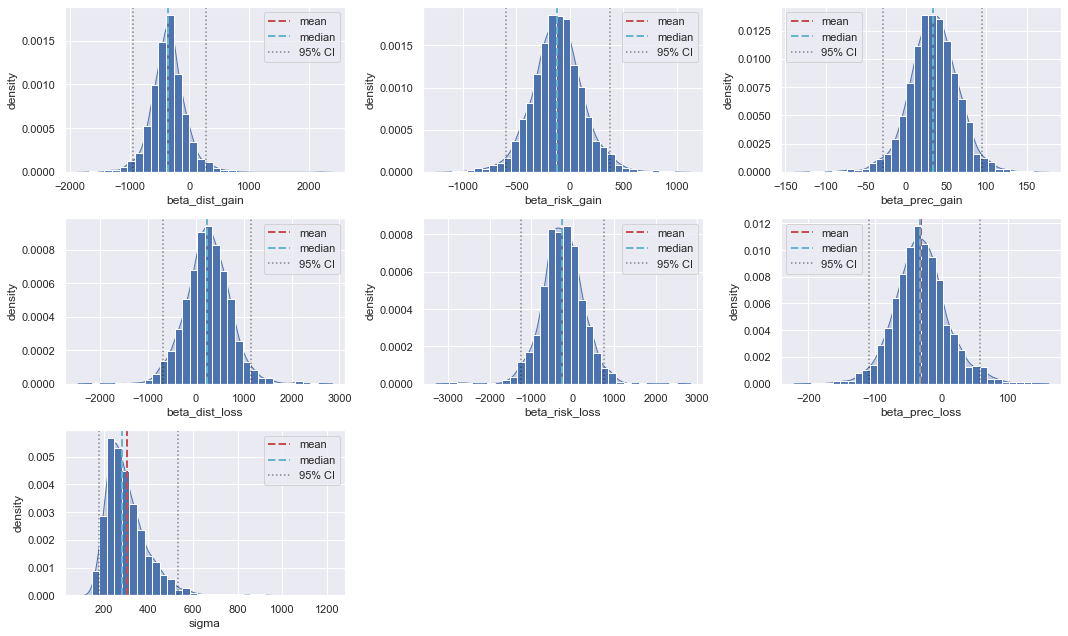

In [27]:
params = (
    "beta_dist_gain", "beta_risk_gain", "beta_prec_gain", 
    "beta_dist_loss", "beta_risk_loss", "beta_prec_loss",
    "sigma")
nrows=3
ncols=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
axes = axes.flatten()

for i, param_name in enumerate(params):

    # Extract trace
    param = fit[param_name]
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    ax = axes[i]
    ax.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    ax.legend()
    
for i in range(len(params), ncols*nrows):
    fig.delaxes(axes[i])
    
plt.tight_layout()    
plt.show()

In gain:
* proba: the more inverse s-shaped, the higher in the hierarchy?
* risk: no relation? tendance: the less risk averse, the higher in hierarchy
* precision: no relation? tendance: the less precise, the higher in hirearchy
In loss: 
* proba: no relation? tendance: the less inverse s-shpaed, the higher in hierarchy?
* risk: no relation? tendance: the less risk averse, the higher in hierarchy
* precision: no relation? tendance: the more precise, the higher in hierarchy